### Initializing a convNP.
* Different variants of the ConvNP, such as the conditional NP (ConvCNP), the Gaussian NP (ConvGNP), and the latent NP (ConvLNP).
* By default, the ConvNP initialises a ConvCNP with Gaussian marginals.

Fusing multiple context sets

Off-the-grid and gridded modalities

Multi-resolution data

Missing data

Predicting at arbitrary target locations

Predicting multiple (disjoint) target sets

Uncertainty quantification

 O(N) inference cost (for most variants)



In [1]:
import logging
logging.captureWarnings(True)

from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.data import construct_circ_time_ds
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import pandas as pd
import numpy as np

# Using the same settings allows use to use pre-downloaded cached data
data_range = ("2015-06-25", "2015-06-30")
extent = "europe"
station_var_IDs = ["TAVG", "PRCP"]
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"]
auxiliary_var_IDs = ["elevation", "tpi"]
cache_dir = "mycache/"

station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
auxiliary_raw_ds = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "1KM", cache=True, cache_dir=cache_dir)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)

data_processor = DataProcessor("deepsensor_config/")
era5_ds = data_processor(era5_raw_ds)
aux_ds, land_mask_ds = data_processor([auxiliary_raw_ds, land_mask_raw_ds], method="min_max")
station_df = data_processor(station_raw_df)

# Add 2D circular day of year variable to land mask context set
dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
#land_mask_ds["cos_D"] = doy_ds["cos_D"]
#land_mask_ds["sin_D"] = doy_ds["sin_D"]

It has to learn how to condition on data from scratch, which requires seeing many examples of different context sets and target sets during training.

In [2]:
import deepsensor.torch
from deepsensor.model import ConvNP

In [3]:
task_loader = TaskLoader(
    context=[station_df["TAVG"], era5_ds, land_mask_ds],
    target=station_df["TAVG"],
    aux_at_targets=aux_ds,
    links=[(0, 0)],
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('TAVG',), ('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [4]:
model = ConvNP(data_processor, task_loader, internal_density=500)

dim_yc inferred from TaskLoader: (1, 3, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.001, np.float32(0.0022727272), np.float32(0.0022727272)]
decoder_scale inferred from TaskLoader: 0.002


### The ConvGNPs internal grid.
* Discretised internal grid.
* Density is defined by internal_density param, internal_density of 500 means i/p patch of input space will contain 500 x 500 internal grid pts.
* Computational cost of model scales quadratically, may lower the internal_density to speed up the training and inference.

### SetCONV context encoding.
* Maps context sets into convNPs internal grid.
* Placing a Gaussian Kernel (x,y) at each observation, weighted by N - D observation values y. Then evaluating the sum on kernesl on the internal grid. 
* N channels are called Data Channels.
* each encoded context set has density channel also, formed using the same gaussian kernel procedure, but without weighing the kernels by the observation values, capturing the density of context observations and revealing areas of missing data.
* o/p SetCONV = concatenation of all density and data channels, for each context set in a task.

In [5]:
task = task_loader("2015-06-25", "all", "all")
encoding = deepsensor.model.nps.compute_encoding_tensor(model, task)
print(f"SetConv encoding tensor shape: {encoding.shape}")

SetConv encoding tensor shape: (1, 8, 432, 608)


#### deepsensor.plot.context_encoding
* context_sampling schemes and visualise the setCONV encoding to see how the cpntext sets are sampled.
* Do the length scale of encoded data seem reasonable?
* Are the channel magnitude in the encoding reasonable ?
* Are there any NaN values ?

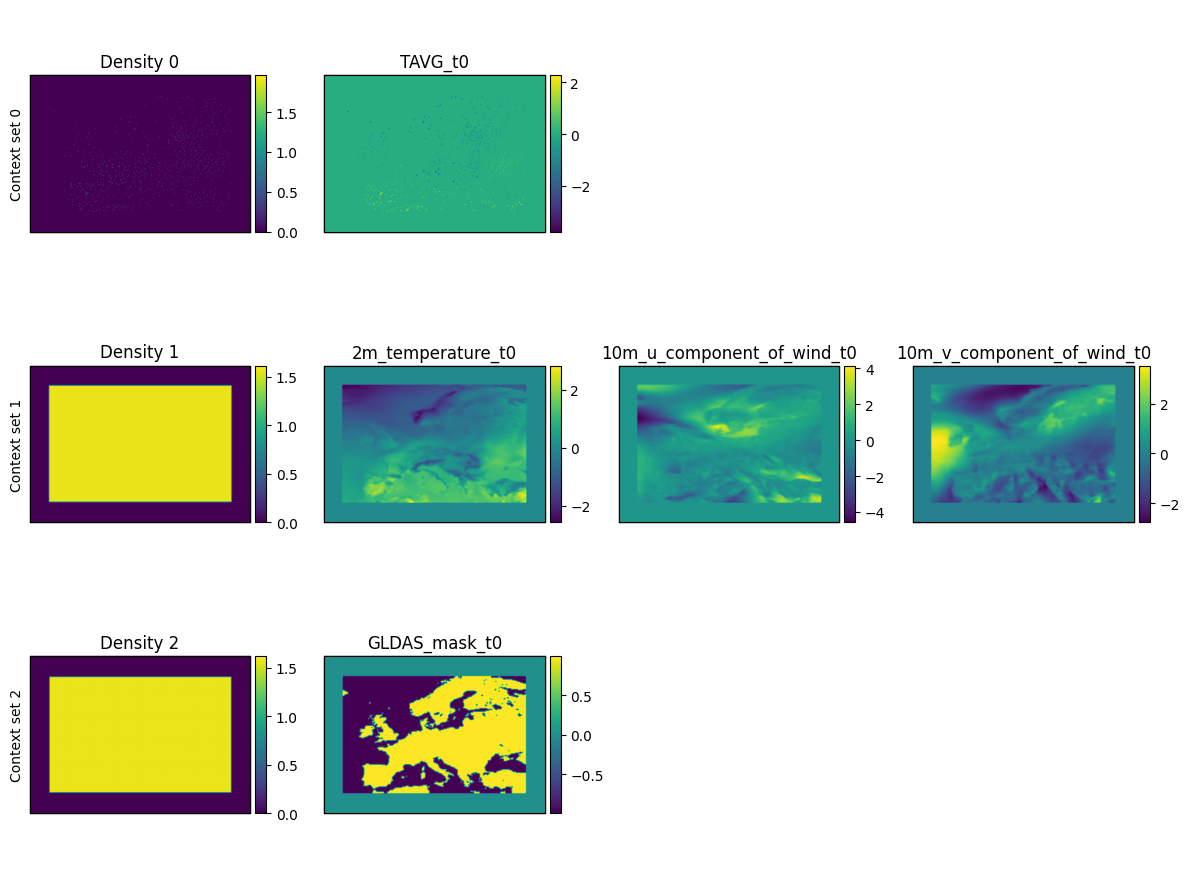

In [6]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)

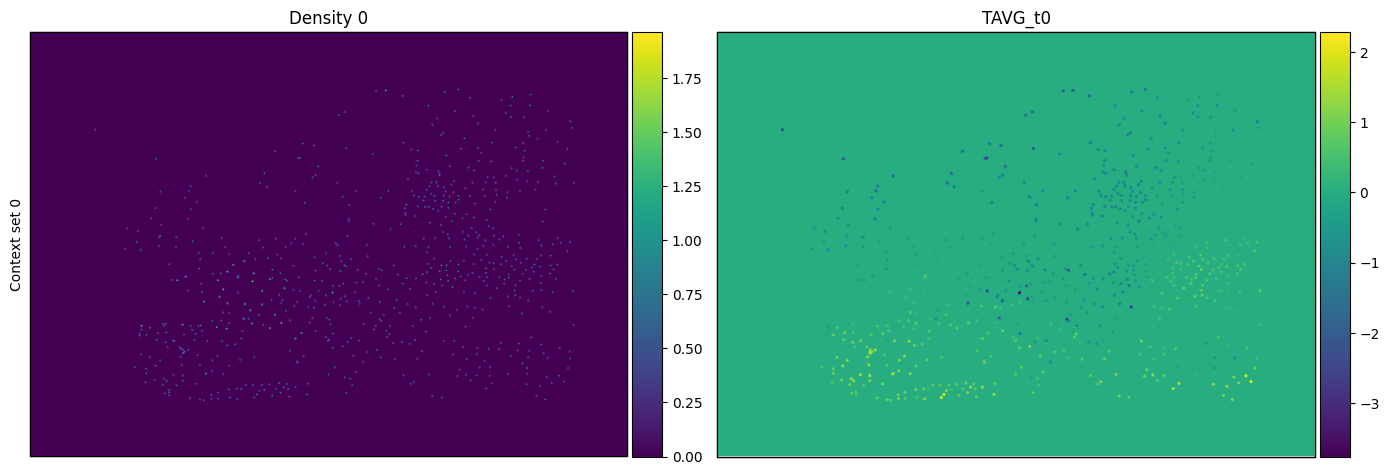

In [8]:
## Zooming on the context set.
fig = deepsensor.plot.context_encoding(model, task, task_loader, context_set_idxs=0, size=7)

### Breaking ConvNP Stationarity using auxiliary variables.

* U Net module is translation equivariant.
* shifting context data results in the shift of corresponding output.Geophysical data can vary significantly.
* Advisable to use auxilliary variables that are physically grounded, like elevation.
* Adding temporal non stationarity, cos_D, sin_D variables.

### Receptive field.

* UNet - Area that influences the prediction at a given pt.
* Receptive field is a fn of UNet architecture. As no of layers, filter size, internal discretization density.
* Can be visualized using 'deepsensor.plot.receptive_field' fn - spatial extent of the receptive field.
* Is the receptive field too large ? - This can cause ecessive zero padding.
* Is the receptive field too small ? model cannot learn correlations greater than the receptive field.
* Can increase/ decrease receptive field by :
* Increasing/decreasing - number of layers in UNet, filter size in UNet, internal discretization density in the UNet.


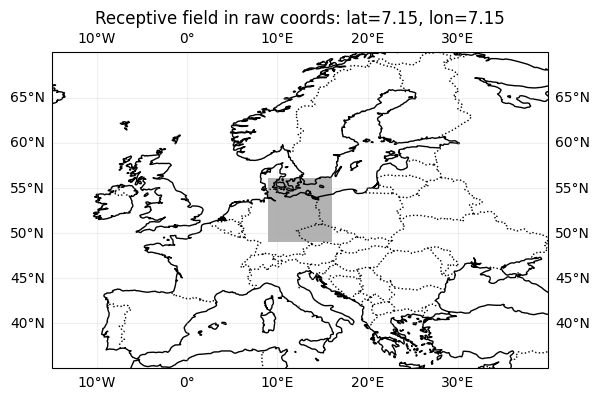

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cf
fig = deepsensor.plot.receptive_field(model.model.receptive_field, data_processor, ccrs.PlateCarree(), "europe")
fig.axes[0].add_feature(cf.BORDERS, linestyle=':')

### The Likelihood Parameter

* o/p distribution of ConvNP.
* cnp - conditional Neural processses, the default, Conditional means that the target variables are modelled as conditionally independent, the model does not learn correlations b/w the target variables.
* cnp-spikes-beta : CNP with two delta functions(spikes) at 0 and 1, and Beta distribution b/w 0 and 1. Model data that lies b/w 0 and 1.Fractional cloud cover.
* bernoulli gamma - CNP with a delta function at 0, and a gamma distribution. data that lies in [0, inf) (e.g. precipitation).
* gnp - This is a generalisation of the CNP that allows for correlations between the target variables.



### Saving and loading a convGNP.


In [8]:
model.save("deepsensor_config")

TypeError: Object of type float32 is not JSON serializable

In [9]:
model_loaded = ConvNP(data_processor, task_loader, "deepsensor_config/")

JSONDecodeError: Expecting value: line 30 column 9 (char 502)

In [43]:
mean_bef = model.mean(task)
mean_loaded = model_loaded.mean(task)
print(np.allclose(mean_bef, mean_loaded))

NameError: name 'model_loaded' is not defined